# Analisi dello spettro di immagini radar (timeseries)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from loader import get_experiment_names, load_experiment
from declutter import declutter

In [2]:
rpm_base_folder_path, rpm_names = get_experiment_names('SR250Mate', 'rpm-ladder', subject='M', antenna='rx0')
recovery_base_folder_path, recovery_names = get_experiment_names('SR250Mate', 'recovery', antenna='rx0')

In [3]:
for name in recovery_names:
    print(name)
    
raw = load_experiment(recovery_base_folder_path, recovery_names[0])

Millenial_M_recovery_20250526-180201_sr250_rx0.npy


In [4]:
for name in rpm_names:
    print(f"'{name}'")

'MillenIAls_M_rpm-ladder_120rpm_20250526-173448_sr250_rx0.npy'
'MillenIAls_M_rpm-ladder_60rpm_20250526-173230_sr250_rx0.npy'
'MillenIAls_M_rpm-ladder_40rpm_20250526-173138_sr250_rx0.npy'
'MillenIAls_M_rpm-ladder_100rpm_20250526-173404_sr250_rx0.npy'
'MillenIAls_M_rpm-ladder_80rpm_20250526-173319_sr250_rx0.npy'


## Variation on fourier analysis
  * fft on raw radar data (no DC bias)
  * fft on energy (no DC bias)
  * fft on energy after declutter
  * fft2d on raw radar data (no DC bias)

In [5]:
# è obbligatorio togliere la media a ogni bin, altrimenti non si vede
# niente sullo spettro
raw_zero_mean = raw - np.mean(raw, axis=0)

raw_energy = np.abs(raw)
raw_energy = raw_energy - np.mean(raw_energy, axis=0)

decluttered = declutter(raw)
decluttered_energy = np.abs(decluttered)

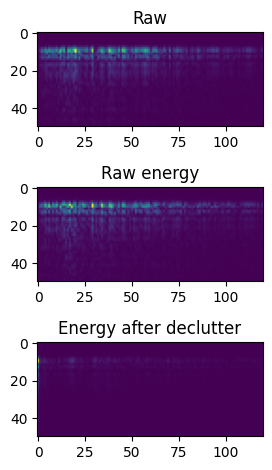

In [6]:
import scipy.fft

fft_raw = scipy.fft.fft(raw_zero_mean, axis=0)
fft_raw_energy = scipy.fft.fft(raw_energy, axis=0)
fft_decluttered_energy = scipy.fft.fft(decluttered_energy, axis=0)
fft_raw_2d = scipy.fft.fft2(raw_zero_mean)

# per selezionare un ingrandimento
nbins = 50
nfreq = 120

fig, ax = plt.subplots(3,1)
ax[0].imshow(np.abs(fft_raw[:nfreq, :nbins]).T)
ax[0].set_title("Raw")
ax[1].imshow(np.abs(fft_raw_energy[:nfreq, :nbins]).T)
ax[1].set_title("Raw energy")
ax[2].imshow(np.abs(fft_decluttered_energy[:nfreq, :nbins]).T)
ax[2].set_title("Energy after declutter")

plt.tight_layout()
plt.show()

L'operazione di declutter elimina l'informazione, non la considereremo più nella analisi

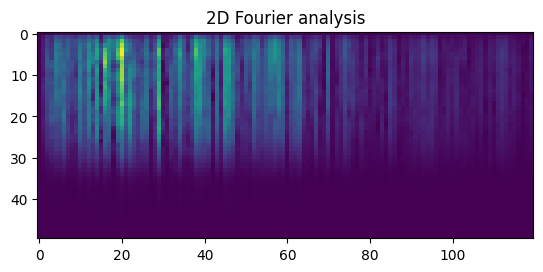

In [7]:
plt.title("2D Fourier analysis")
plt.imshow(np.abs(fft_raw_2d[:nfreq, :nbins]).T)
plt.show()

Questo spettro 2D dovrebbe catturare i fenomeni che hanno regolarità temporale, ma anche spaziale. Un esempio potrebbe essere il corpo che respirando oscilla tra due estremi. Non è ancora chiaro cosa si potrebbe estrarre da questo grafico. È interessante quello che succede al bin 20.

## Bin selection for 1D Fourier analysis
Mostriamo due tecniche per selezionare solo un bin da cui estrarre lo spettro. Ricordiamo che in questo processo si perde dell'informazione:
  1. media tra bin in un range (avendo cura di escludere i primi bin che contengono il cross-talk delle antenne)
  2. PCA sui bin

In [8]:
name = 'MillenIAls_M_rpm-ladder_40rpm_20250526-173138_sr250_rx0.npy'
raw = load_experiment(rpm_base_folder_path, name)

In [9]:
# per generare un asse delle frequenze in BPM
samples_per_window = raw.shape[0]
samples_per_second = 20 # hardcoded from logger.py
seconds_per_window = samples_per_window / samples_per_second

base_frequency = 1.0 / seconds_per_window
frequency_range_hz = np.arange(raw.shape[0]) * base_frequency
frequency_range_bpm = 60 * frequency_range_hz

### Mean over bins + fft or the other way?

In [10]:
# è obbligatorio togliere la media a ogni bin, altrimenti non si vede
# niente sullo spettro
raw_zero_mean = raw - np.mean(raw, axis=0)

mean_over_bins = np.mean(raw_zero_mean[:, :nbins], axis=1)
fft_mean_over_bins = scipy.fft.fft(mean_over_bins)

fft_raw = scipy.fft.fft(raw_zero_mean[:, :nbins], axis=0)
mean_fft = np.mean(fft_raw, axis=1)

print(np.abs(np.max(fft_mean_over_bins - mean_fft)))

0.0003383058


Sono praticamente equivalenti. Questo ha ripercussioni dal punto di vista della performance perchè è più conveniente mediare i bin e poi prendere una sola fft.

### Energy or raw?

In [11]:
energy = np.abs(raw)
energy_single_bin = np.mean(energy[:, :nbins], axis=1)
energy_zero_mean = energy_single_bin - np.mean(energy_single_bin)

fft_energy = scipy.fft.fft(energy_zero_mean)

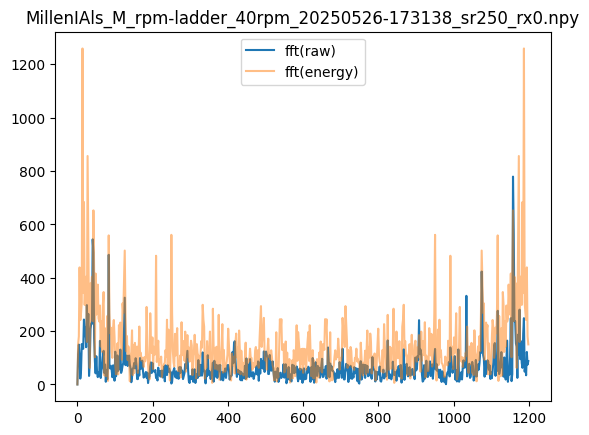

In [12]:
plt.title(name)
plt.plot(frequency_range_bpm, np.abs(fft_mean_over_bins), label='fft(raw)')
plt.plot(frequency_range_bpm, np.abs(fft_energy), label='fft(energy)', alpha=0.5)
plt.legend()
plt.show()

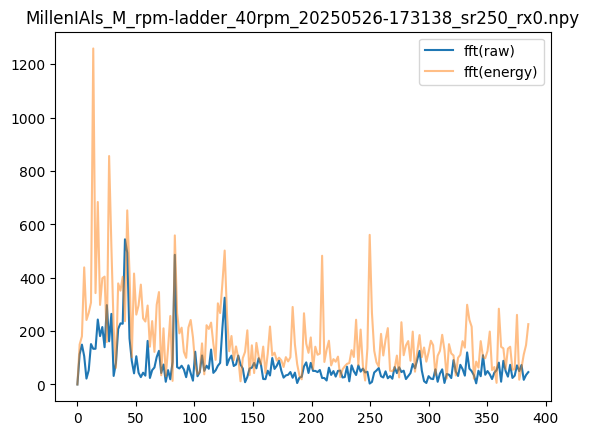

In [13]:
# versione zoom
nsamples = 200

plt.title(name)
plt.plot(frequency_range_bpm[:nsamples], np.abs(fft_mean_over_bins)[:nsamples], label='fft(raw)')
plt.plot(frequency_range_bpm[:nsamples], np.abs(fft_energy)[:nsamples], label='fft(energy)', alpha=0.5)
plt.legend()
plt.show()

Non è chiaro quale dei due spettri sia più informativo. Lo spettro dell'energia contiene più picchi, ma non sappiamo a priori quali siano più significativi. Sarà compito di un modello di deep learning determinare quale input sia più adatto per il task di classificazione, così come determinare se l'informazione da più antenne è utile.